In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# market cap

In [2]:
marketdata = pd.read_csv("market_cap_data_cmc.csv")
marketdata.shape

(5845, 11)

In [3]:
# 获取所有交易日
start_date = datetime.date(2009, 1, 1)
end_date = datetime.date(2025, 1, 1)
date_range = []
delta = datetime.timedelta(days=1)  # 定义时间间隔为1天
while start_date <= end_date:
    date_range.append(start_date)
    start_date += delta
len(date_range)

5845

In [4]:
# 2018/9/10
marketdata = marketdata[marketdata["date_time"]>"2018-09-10"]
marketdata.reset_index(drop=True, inplace=True)
marketdata.shape


(2305, 11)

In [5]:
# 处理缺失值
df = marketdata.iloc[:,1:]
# 向前填充缺失值
df_forward = df.fillna(method='ffill')

# 向后填充缺失值
df_backward = df.fillna(method='bfill')

# 计算前后填充值的平均数
df_filled = (df_forward + df_backward) / 2

C:\Users\PuLin\AppData\Local\Temp\ipykernel_13752\4136803884.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_forward = df.fillna(method='ffill')
C:\Users\PuLin\AppData\Local\Temp\ipykernel_13752\4136803884.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_backward = df.fillna(method='bfill')


In [6]:
df_filled.iloc[:-1,:].isnull().sum()

btc_marketCap                      0
btc_marketCap_percentage           0
eth_marketCap                      0
eth_marketCap_percentage           0
stablecoin_marketCap               0
stablecoin_marketCap_percentage    0
altcoin_marketCap                  0
altcoin_marketCap_percentage       0
total_marketCap                    0
btc_price                          0
dtype: int64

In [7]:
marketdata_filled = pd.concat([marketdata.iloc[:-1,0], df_filled.iloc[:-1,:]],axis=1)
marketdata_filled.isnull().sum()

date_time                          0
btc_marketCap                      0
btc_marketCap_percentage           0
eth_marketCap                      0
eth_marketCap_percentage           0
stablecoin_marketCap               0
stablecoin_marketCap_percentage    0
altcoin_marketCap                  0
altcoin_marketCap_percentage       0
total_marketCap                    0
btc_price                          0
dtype: int64

In [8]:
# 处理异常值_替换极端值为前后均值
marketdata_filled["altcoin_marketCap_ptc_change"] = abs(marketdata_filled["altcoin_marketCap"].pct_change(1))
quantile_99 = marketdata_filled["altcoin_marketCap_ptc_change"].quantile(0.99)
quantile_99
# 将大于0.99分位数处的altcoin_marketCap的极端值 使用前后均值填充
excess_quantile_99_index = marketdata_filled[marketdata_filled["altcoin_marketCap_ptc_change"]>quantile_99].index
for i in excess_quantile_99_index:
    if i==0 or i==marketdata_filled.shape[0]-1:
        continue
    marketdata_filled.loc[i,"altcoin_marketCap"] = (marketdata_filled.loc[i-1,"altcoin_marketCap"]+marketdata_filled.loc[i+1,"altcoin_marketCap"])/2
    marketdata_filled.loc[i,"total_marketCap"] = marketdata_filled.loc[i,"btc_marketCap"]+marketdata_filled.loc[i,"eth_marketCap"]+\
    marketdata_filled.loc[i,"stablecoin_marketCap"] + marketdata_filled.loc[i,"altcoin_marketCap"]

marketdata_filled["stablecoin_marketCap_ptc_change"] = abs(marketdata_filled["stablecoin_marketCap"].pct_change(1))
quantile_95 = marketdata_filled["stablecoin_marketCap_ptc_change"].quantile(0.99)
quantile_95
# 将大于0.99分位数处的stablecoin_marketCap的极端值 使用前后均值填充
excess_quantile_95_index = marketdata_filled[marketdata_filled["stablecoin_marketCap_ptc_change"]>quantile_95].index
for i in excess_quantile_95_index:
    if i==0 or i==marketdata_filled.shape[0]-1:
        continue
    marketdata_filled.loc[i,"stablecoin_marketCap"] = (marketdata_filled.loc[i-1,"stablecoin_marketCap"]+marketdata_filled.loc[i+1,"stablecoin_marketCap"])/2
    marketdata_filled.loc[i,"total_marketCap"] = marketdata_filled.loc[i,"btc_marketCap"]+marketdata_filled.loc[i,"eth_marketCap"]+\
                    marketdata_filled.loc[i,"stablecoin_marketCap"] + marketdata_filled.loc[i,"altcoin_marketCap"]

# 将大于0.99分位数处的eth_marketCap的极端值 使用前后均值填充
# marketdata_filled["eth_marketCap_ptc_change"] = abs(marketdata_filled["eth_marketCap"].pct_change(1))
# quantile_eth = marketdata_filled["eth_marketCap_ptc_change"].quantile(0.99)
# quantile_eth
# excess_quantile_95_index = marketdata_filled[marketdata_filled["eth_marketCap_ptc_change"]>quantile_eth].index
# for i in excess_quantile_95_index:
#     if i==0 or i==marketdata_filled.shape[0]-1:
#         continue
#     marketdata_filled.loc[i,"eth_marketCap"] = (marketdata_filled.loc[i-1,"eth_marketCap"]+marketdata_filled.loc[i+1,"eth_marketCap"])/2
#     marketdata_filled.loc[i,"total_marketCap"] = marketdata_filled.loc[i,"btc_marketCap"] + marketdata_filled.loc[i,"eth_marketCap"]+\
#     marketdata_filled.loc[i,"stablecoin_marketCap"] + marketdata_filled.loc[i,"altcoin_marketCap"]

marketdata_filled["btc_marketCap_percentage"] = marketdata_filled["btc_marketCap"] / marketdata_filled["total_marketCap"]
marketdata_filled["eth_marketCap_percentage"] = marketdata_filled["eth_marketCap"] / marketdata_filled["total_marketCap"]
marketdata_filled["stablecoin_marketCap_percentage"] = marketdata_filled["stablecoin_marketCap"] / marketdata_filled["total_marketCap"]
marketdata_filled["altcoin_marketCap_percentage"] = marketdata_filled["altcoin_marketCap"] / marketdata_filled["total_marketCap"]

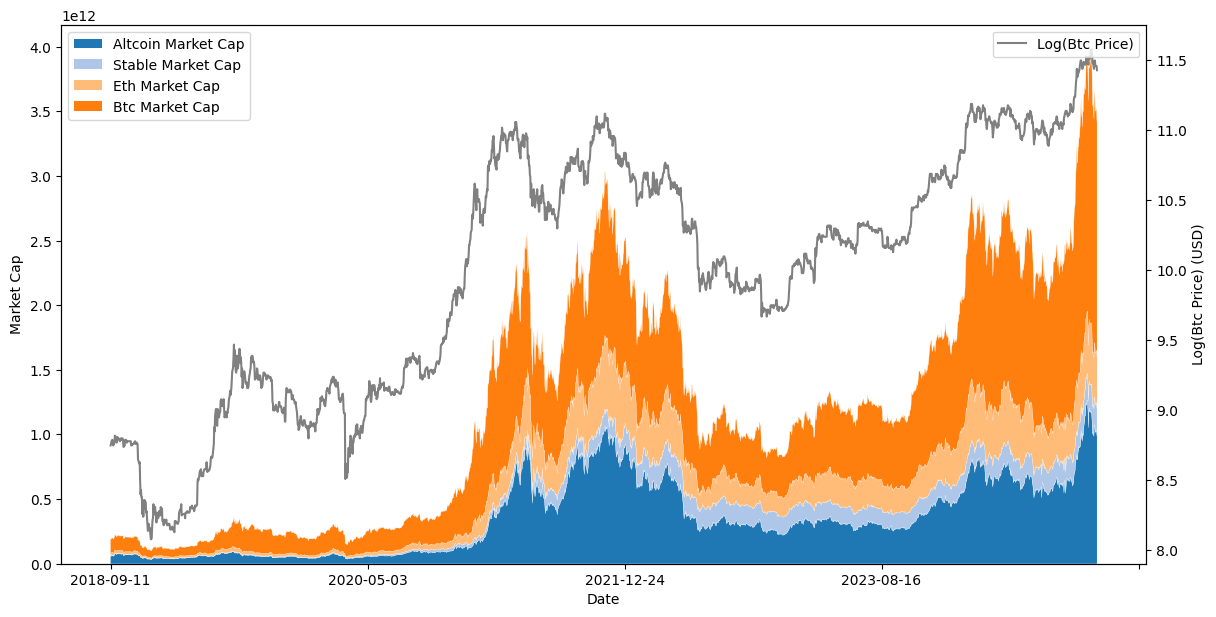

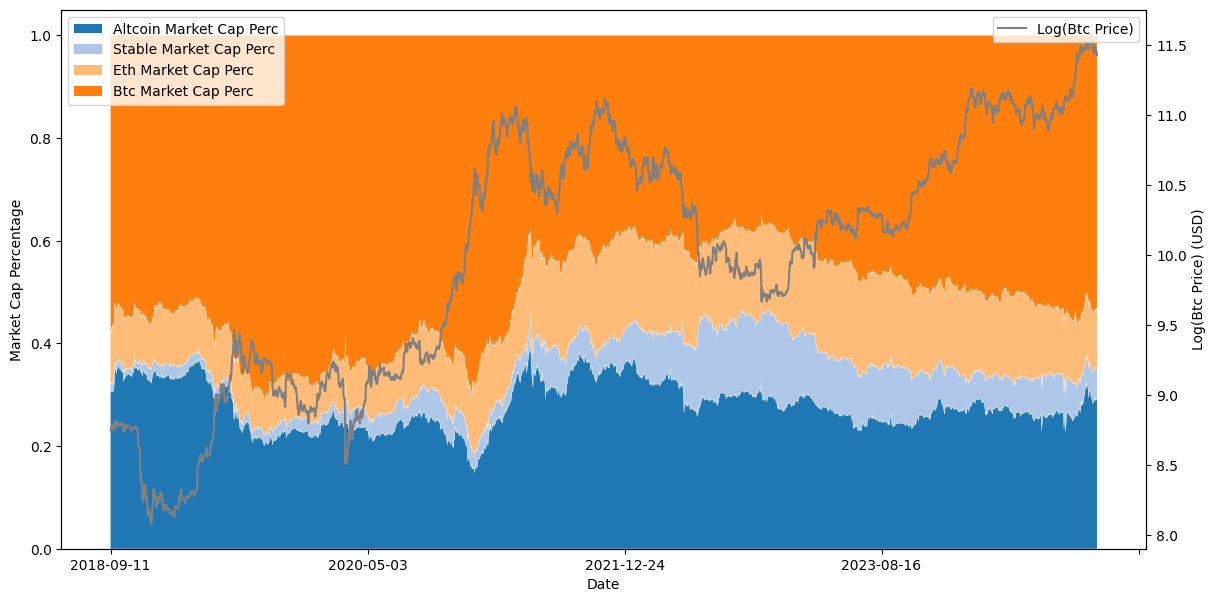

In [9]:

from market_cap_plot import plotMarketCap,plotMarketCapPercentage
plotMarketCap(marketdata_filled)
plotMarketCapPercentage(marketdata_filled)

In [10]:
marketdata_filled.columns

Index(['date_time', 'btc_marketCap', 'btc_marketCap_percentage',
       'eth_marketCap', 'eth_marketCap_percentage', 'stablecoin_marketCap',
       'stablecoin_marketCap_percentage', 'altcoin_marketCap',
       'altcoin_marketCap_percentage', 'total_marketCap', 'btc_price',
       'altcoin_marketCap_ptc_change', 'stablecoin_marketCap_ptc_change',
       'eth_marketCap_ptc_change'],
      dtype='object')

In [11]:
marketdata_filled.iloc[:,:-3].to_csv("marketdata_filled.csv", index=False)

# FDV

In [12]:
fdvdata = pd.read_csv("fdv_data_cmc.csv")
# 只保留2023/1/28之后
fdvdata = fdvdata[fdvdata["date_time"]>"2023-01-28"]
fdvdata.reset_index(drop=True, inplace=True)
fdvdata.shape

(704, 11)

In [13]:
fdvdata.isnull().sum()

date_time                    0
btc_FDV                      3
btc_FDV_percentage           3
eth_FDV                      3
eth_FDV_percentage           3
stablecoin_FDV               1
stablecoin_FDV_percentage    3
altcoin_FDV                  3
altcoin_FDV_percentage       3
total_FDV                    1
btc_price                    1
dtype: int64

In [14]:
# 处理缺失值
df = fdvdata.iloc[:,1:].astype(float)
# 向前填充缺失值
df_forward = df.fillna(method='ffill')

# 向后填充缺失值
df_backward = df.fillna(method='bfill')

# 计算前后填充值的平均数
df_filled = (df_forward + df_backward) / 2

C:\Users\PuLin\AppData\Local\Temp\ipykernel_21352\3029017416.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_forward = df.fillna(method='ffill')
C:\Users\PuLin\AppData\Local\Temp\ipykernel_21352\3029017416.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_backward = df.fillna(method='bfill')


In [15]:
df_filled.iloc[:-1,:].isnull().sum()

btc_FDV                      0
btc_FDV_percentage           0
eth_FDV                      0
eth_FDV_percentage           0
stablecoin_FDV               0
stablecoin_FDV_percentage    0
altcoin_FDV                  0
altcoin_FDV_percentage       0
total_FDV                    0
btc_price                    0
dtype: int64

In [16]:
fdv_filled = pd.concat([fdvdata.iloc[:-1,0], df_filled.iloc[:-1,:]],axis=1)
fdv_filled.isnull().sum()

date_time                    0
btc_FDV                      0
btc_FDV_percentage           0
eth_FDV                      0
eth_FDV_percentage           0
stablecoin_FDV               0
stablecoin_FDV_percentage    0
altcoin_FDV                  0
altcoin_FDV_percentage       0
total_FDV                    0
btc_price                    0
dtype: int64

In [17]:
# 处理异常值_替换极端值为前后均值
fdv_filled["altcoin_FDV_ptc_change"] = abs(fdv_filled["altcoin_FDV"].pct_change(1))
# fdv_filled["altcoin_FDV_ptc_change"].describe()
quantile_99 = fdv_filled["altcoin_FDV_ptc_change"].quantile(0.99)
quantile_99
excess_quantile_99_index = fdv_filled[fdv_filled["altcoin_FDV_ptc_change"]>quantile_99].index
excess_quantile_99_index

# 将大于0.99分位数处的stablecoin_FDV的极端值 使用前后均值填充
fdv_filled["stablecoin_FDV_ptc_change"] = abs(fdv_filled["stablecoin_FDV"].pct_change(1))
quantile_95 = fdv_filled["stablecoin_FDV_ptc_change"].quantile(0.99)
quantile_95
excess_quantile_95_index = fdv_filled[fdv_filled["stablecoin_FDV_ptc_change"]>quantile_95].index
for i in excess_quantile_95_index:
    if i==0 or i==fdv_filled.shape[0]-1:
        continue
    fdv_filled.loc[i,"stablecoin_FDV"] = (fdv_filled.loc[i-1,"stablecoin_FDV"]+fdv_filled.loc[i+1,"stablecoin_FDV"])/2
    fdv_filled.loc[i,"total_FDV"] = fdv_filled.loc[i,"btc_FDV"] + fdv_filled.loc[i,"eth_FDV"]+\
    fdv_filled.loc[i,"stablecoin_FDV"] + fdv_filled.loc[i,"altcoin_FDV"]

# 将大于0.99分位数处的eth_FDV的极端值 使用前后均值填充
fdv_filled["eth_FDV_ptc_change"] = abs(fdv_filled["eth_FDV"].pct_change(1))
quantile_95 = fdv_filled["eth_FDV_ptc_change"].quantile(0.99)
quantile_95
excess_quantile_95_index = fdv_filled[fdv_filled["eth_FDV_ptc_change"]>quantile_95].index
for i in excess_quantile_95_index:
    if i==0 or i==fdv_filled.shape[0]-1:
        continue
    fdv_filled.loc[i,"eth_FDV"] = (fdv_filled.loc[i-1,"eth_FDV"]+fdv_filled.loc[i+1,"eth_FDV"])/2
    fdv_filled.loc[i,"total_FDV"] = fdv_filled.loc[i,"btc_FDV"] + fdv_filled.loc[i,"eth_FDV"]+\
    fdv_filled.loc[i,"stablecoin_FDV"] + fdv_filled.loc[i,"altcoin_FDV"]

fdv_filled["btc_FDV_percentage"] = fdv_filled["btc_FDV"] / fdv_filled["total_FDV"]
fdv_filled["eth_FDV_percentage"] = fdv_filled["eth_FDV"] / fdv_filled["total_FDV"]
fdv_filled["stablecoin_FDV_percentage"] = fdv_filled["stablecoin_FDV"] / fdv_filled["total_FDV"]
fdv_filled["altcoin_FDV_percentage"] = fdv_filled["altcoin_FDV"] / fdv_filled["total_FDV"]


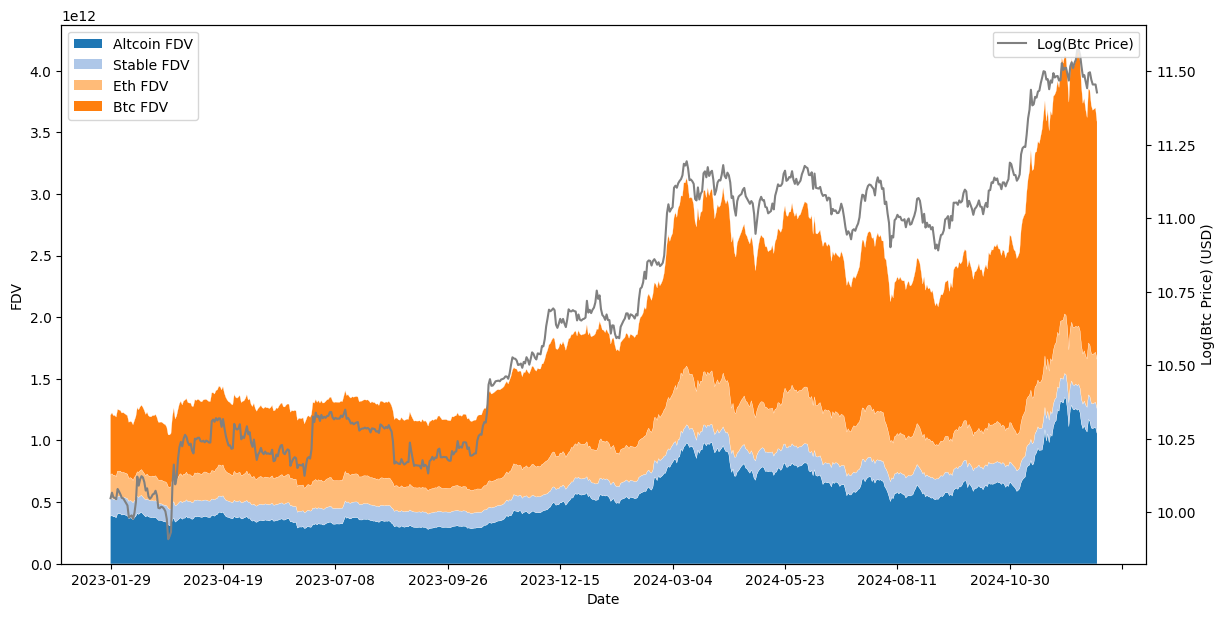

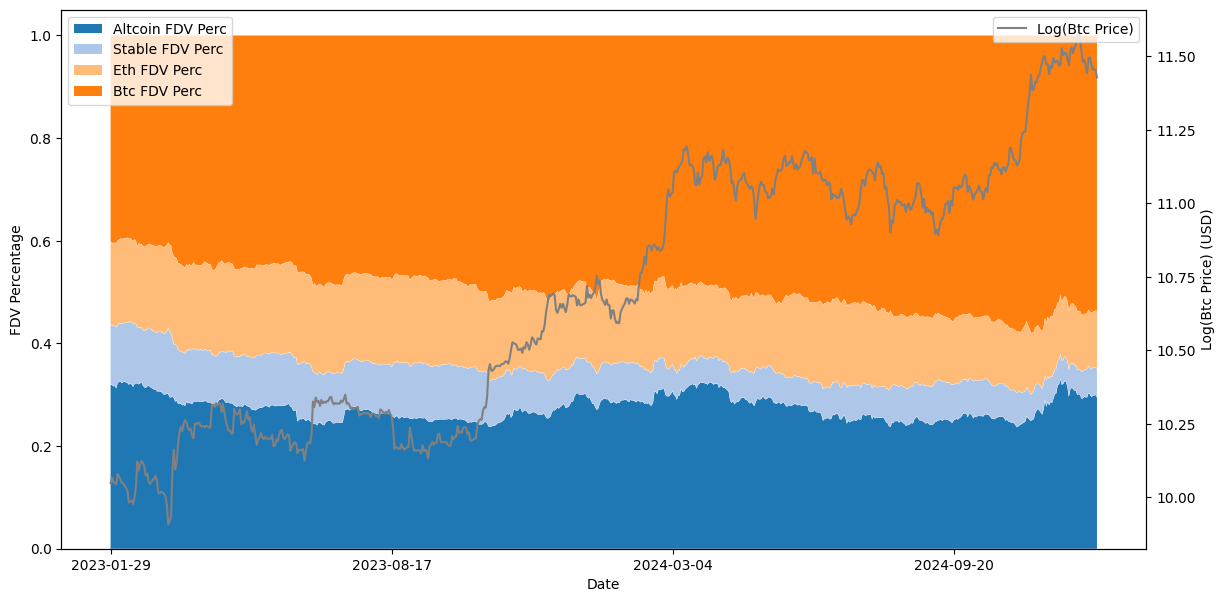

In [18]:

from fdv_plot import plotFDV,plotFDVPercentage
plotFDV(fdv_filled)
plotFDVPercentage(fdv_filled)

In [19]:
fdv_filled.iloc[:,:-3].to_csv("fdv_filled.csv",index=False)

In [20]:
marketdata_filled = pd.read_csv("marketdata_filled.csv")
fdv_filled = pd.read_csv("fdv_filled.csv")

In [21]:
marketdata_filled.isnull().sum().sum()

0

In [22]:
fdv_filled.isnull().sum().sum()

0

In [23]:
result = marketdata_filled.merge(fdv_filled.iloc[:, :-1], on="date_time", how="left")
result.to_csv("alldata.csv", index=False)

In [24]:
result

,date_time,btc_marketCap,btc_marketCap_percentage,eth_marketCap,eth_marketCap_percentage,stablecoin_marketCap,stablecoin_marketCap_percentage,altcoin_marketCap,altcoin_marketCap_percentage,total_marketCap,btc_price,btc_FDV,btc_FDV_percentage,eth_FDV,eth_FDV_percentage,stablecoin_FDV,stablecoin_FDV_percentage,altcoin_FDV,altcoin_FDV_percentage,total_FDV
0,2018-09-11,1.091199e+11,0.577682,1.885838e+10,0.099836,2.971124e+09,0.015729,5.794327e+10,0.306752,1.888927e+11,6321.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-09-12,1.096615e+11,0.580524,1.868532e+10,0.098916,2.963027e+09,0.015686,5.759106e+10,0.304874,1.889009e+11,6351.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-09-13,1.125310e+11,0.572253,2.013784e+10,0.102407,2.979624e+09,0.015152,6.099693e+10,0.310187,1.966454e+11,6517.310000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-09-14,1.124625e+11,0.569087,2.159037e+10,0.109252,2.973870e+09,0.015049,6.059235e+10,0.306612,1.976190e+11,6512.710000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-09-15,1.130003e+11,0.564668,2.274965e+10,0.113681,2.973377e+09,0.014858,6.139465e+10,0.306792,2.001180e+11,6543.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,2024-12-27,1.900199e+12,0.537537,4.026054e+11,0.113891,2.131307e+11,0.060291,1.019074e+12,0.288281,3.535010e+12,95962.588945,2.015214e+12,0.541882,4.026054e+11,0.108259,1.999348e+11,0.053762,1.101166e+12,0.296098,3.718920e+12
2300,2024-12-28,1.869717e+12,0.534239,3.999031e+11,0.114265,2.135646e+11,0.061022,1.016592e+12,0.290473,3.499777e+12,94421.139968,1.982844e+12,0.538979,3.999031e+11,0.108702,2.003197e+11,0.054451,1.095820e+12,0.297867,3.678886e+12
2301,2024-12-29,1.869915e+12,0.532699,4.028726e+11,0.114770,2.132990e+11,0.060764,1.024179e+12,0.291767,3.510266e+12,94428.851804,1.983006e+12,0.537621,4.028726e+11,0.109224,2.003052e+11,0.054306,1.102301e+12,0.298849,3.688484e+12
2302,2024-12-30,1.870114e+12,0.531159,4.058420e+11,0.115269,2.130935e+11,0.060524,1.031766e+12,0.293048,3.520816e+12,94436.563640,1.983168e+12,0.536269,4.058420e+11,0.109744,2.002907e+11,0.054161,1.108782e+12,0.299826,3.698082e+12


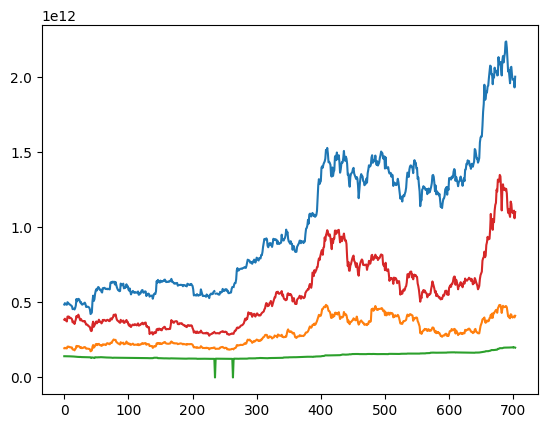

In [43]:
plt.plot(fdvdata["btc_FDV"])
plt.plot(fdvdata["eth_FDV"])
plt.plot(fdvdata["stablecoin_FDV"])
plt.plot(fdvdata["altcoin_FDV"])